# Introduction and setup

In this project, we consider a collection of image files. Each file shows a patch of cells from a tissue biopsy, and each file has been labeled by expert diagnosticians according to whether its center region shows signs of metastatic cancer. We are interested in developing a convolutional neural network able to classify novel images of cells according to whether those cells are malignant or benign. We will train two architectures, one with a convolutional block custom-trained with the labeled image files and another with a pretrained feature extraction layer. The following code block imports the libraries, classes, and functions we will use.

In [1]:
import numpy as np
import pandas as pd
from cv2 import imread
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Layer, Input, Dense, Conv2D, Flatten, MaxPooling2D, Dropout, 
    BatchNormalization, GlobalAveragePooling2D, LeakyReLU
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.applications import VGG16

The image files for training and validation are stored in a single directory. The following code creates a data frame `df` from a CSV with image file names and labels.

In [10]:
path = "/kaggle/input/histopathologic-cancer-detection/"
filename = "train_labels.csv"
df = pd.read_csv(path + filename)
df["id"] = df["id"] + ".tif"
df["label"] = df["label"].astype(str)

# Exploratory data analysis

Before partitioning the images into training and validation sets, we inspect the dimensions and color composition of each image file referenced in `df`.

In [28]:
df["x"] = np.zeros((df.shape[0],1))
df["y"] = np.zeros((df.shape[0],1))
df["z"] = np.zeros((df.shape[0],1))
df["mean_r"] = np.zeros((df.shape[0],1))
df["mean_g"] = np.zeros((df.shape[0],1))
df["mean_b"] = np.zeros((df.shape[0],1))
for i in range(df.shape[0]): 
    name = df.iloc[i,]["id"]
    img = imread(path + "train/" + name)
    df.iloc[i,2] = img.shape[0]
    df.iloc[i,3] = img.shape[1]
    df.iloc[i,4] = img.shape[2]
    df.iloc[i,5] = img[:,:,0].mean()
    df.iloc[i,6] = img[:,:,1].mean()
    df.iloc[i,7] = img[:,:,2].mean()

In [29]:
df.loc[:,["x","y","z"]].describe()

,x,y,z
count,220025.0,220025.0,220025.0
mean,96.0,96.0,3.0
std,0.0,0.0,0.0
min,96.0,96.0,3.0
25%,96.0,96.0,3.0
50%,96.0,96.0,3.0
75%,96.0,96.0,3.0
max,96.0,96.0,3.0


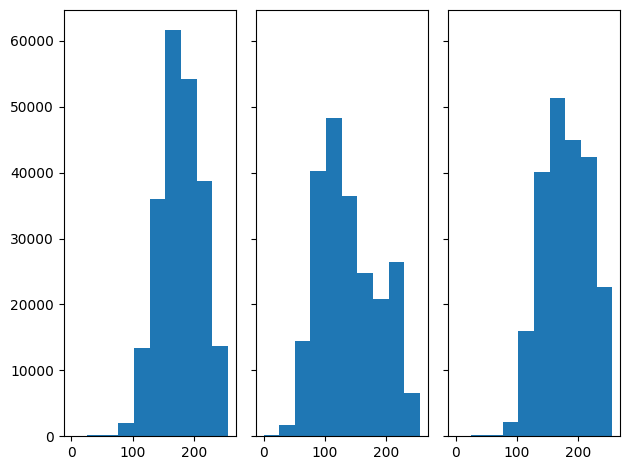

In [30]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)
axs[0].hist(df["mean_r"])
axs[1].hist(df["mean_g"])
axs[2].hist(df["mean_b"])
plt.show()

Summary statistics for the dimensional data shows that all the images have the same size: $96 \times 96$ pixels and three color channels. Histograms of the average values for each color channel in each image show approximately normal distributions concentrated in the interval $[0,255]$, as we expect for image files.

Next, we consider whether the distribution of positive and negative labels is balanced.

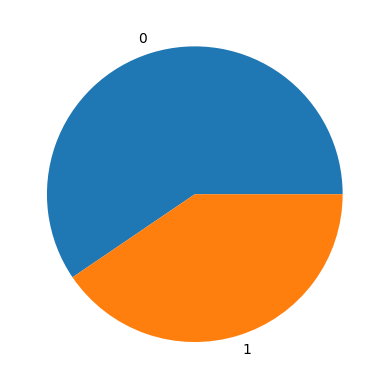

In [34]:
label_counts = df["label"].value_counts()
plt.pie(label_counts, labels = label_counts.index)
plt.show()

Images of malignant cells are a slight minority in our data a set. In principle, this could introduce a bias toward classifying new images as benign, but we believe such a bias is likely to be negligible. For now, we will maintain the small imbalance when we partition the images.

In [12]:
df_train, df_val = train_test_split(df, test_size = 0.2, random_state = 318)

# Preprocessing

The `ImageDataGenerator` class implements a method `flow_from_dataframe()` for preprocessing image files referenced in a data frame for use by an instance of a Keras `Sequential` model.

In [13]:
datagen = ImageDataGenerator(rescale = 1/255)
train_loader = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = path + "train/",
    x_col = "id",
    y_col = "label",
    class_mode = "binary",
    target_size = (96, 96)
)
val_loader = datagen.flow_from_dataframe(
    dataframe = df_val,
    directory = path + "train/",
    x_col = "id",
    y_col = "label",
    class_mode = "binary",
    target_size = (96, 96)
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Model 1: Custom convolutional neural net

For our first model, we will implement a single convolutional block. The documentation accompanying our data set indicates that the images were labeled according to whether their central $32 \times 32$ pixel regions appeared to have cancerous cells. As a starting point, we will implement our convolutional block with $32$ filters of dimension $3 \times 3 \times 3$ so that the output of the final filter represents a $32 \times 32$ image. Whether to adjust the number of filters or to add additional convolutional blocks is a possible consideration for later fine tuning, but this seems like a reasonable first guess at a good field of view. Between the convolutional layer and hidden layers, we implement batch normalization and a dropout layer to reduce the risk of overfitting, a leaky ReLU activation layer to address potential vanishing gradients. For flattening, we use average pooling to attempt to pass as much information as possible from the convolutional block to the hidden layers.

We implement two dense hidden layers with $128$ and $64$ nodes and ReLU activation, followed by an output layer with a single node and sigmoid activation for binary classification. To control overfitting further, we implement L2 regularization within each hidden layer, and we implement batch normalization and dropout after each hidden layer.

In [8]:
cnn = Sequential([
    # convolutional block
    Input((96,96,3)),
    Conv2D(32, (3, 3), padding='valid'),
    BatchNormalization(),
    LeakyReLU(),
    GlobalAveragePooling2D(),
    Dropout(0.25),
    
    # dense layers
    Dense(
        128, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.5),
    Dense(
        64, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.5),

    # output layer
    Dense(1, activation='sigmoid')  # Adjusted for binary classification
])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 94, 94, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,337 (56.00 KB)

 Trainable params: 13,889 (54.25 KB)

 Non-trainable params: 448 (1.75 KB)

We use `Adam` for optimization, and we implement early stopping to avoid overfitting and improve training efficiency. As this is a binary classification problem, binary cross-entropy is a suitable loss function. We will measure classification performance by the area under the model's ROC curve. (Other classification metrics are possible, but the image data is from a Kaggle competition judeged according to area under ROC curves, so choosing this metric allows for comparison to other models.) For our first iteration of the model, we train in 30 epochs.

In [11]:
optimizer = Adam(learning_rate = 0.0001)
early_stop = EarlyStopping(
    monitor = 'val_auc', 
    patience = 5, 
    restore_best_weights = True
)
cnn.compile(
    optimizer = optimizer, 
    loss = 'binary_crossentropy', 
    metrics = [AUC(name = 'auc')]
)
cnn_history = cnn.fit(
    train_loader,                
    validation_data = val_loader,     
    epochs = 30,
    callbacks = [early_stop],
    verbose = 1
) 

Epoch 1/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 282s 50ms/step - auc: 0.6918 - loss: 0.8509 - val_auc: 0.8484 - val_loss: 0.5931
Epoch 2/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 285s 52ms/step - auc: 0.8075 - loss: 0.6347 - val_auc: 0.8513 - val_loss: 0.6510
Epoch 3/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 289s 52ms/step - auc: 0.8298 - loss: 0.5770 - val_auc: 0.8663 - val_loss: 0.5335
Epoch 4/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 274s 50ms/step - auc: 0.8444 - loss: 0.5327 - val_auc: 0.8484 - val_loss: 0.5253
Epoch 5/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 271s 49ms/step - auc: 0.8467 - loss: 0.5135 - val_auc: 0.8669 - val_loss: 0.5353
Epoch 6/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 270s 49ms/step - auc: 0.8507 - loss: 0.4990 - val_auc: 0.8765 - val_loss: 0.5009
Epoch 7/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 268s 49ms/step - auc: 0.8551 - loss: 0.4864 - val_auc: 0.8594 - val_loss: 0.6982
Epoch 8/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 266s 48ms/step - auc: 0.8567 - loss: 0.4795 - val_auc: 0.8825 - val_loss: 0.4549
Epoch 9/30
5501/

In [13]:
cnn.save("cnn.keras")

Though relatively simple in design, our initial convolutional neural network was able to achieve a maximum area of $0.8893$ under its ROC curve, and training appeared to converge after approximately 15 epochs.

# Model 2: Pretrained feature extraction layer

In the first model, we made some educated guesses about a suitable convolutional block structure. In the second model, we use the pretrained `VGG16` model to do feature extraction, the results of which are run through through the same hidden and output layer architecture as in the first model. We wish to see if the pretrained feature extractor can lead to good classification results without any of its own retraining.

In [6]:
input_layer = Input((96, 96, 3))
model_vgg16 = VGG16(
    weights = 'imagenet',
    input_tensor = input_layer,
    include_top = False
)
model_vgg16.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
cnn_pretrained = Sequential([
    # pretrained feature extraction block
    Input((96,96,3)),
    model_vgg16,
    BatchNormalization(),
    LeakyReLU(),
    GlobalAveragePooling2D(),
    Dropout(0.25),
    
    # dense layers
    Dense(
        128, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.5),
    Dense(
        64, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(0.001)
    ),
    BatchNormalization(),
    Dropout(0.5),

    # output layer
    Dense(1, activation='sigmoid')  # Adjusted for binary classification
])
cnn_pretrained.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3, 3, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,791,489 (56.43 MB)

 Trainable params: 75,393 (294.50 KB)

 Non-trainable params: 14,716,096 (56.14 MB)

Even though the convolutional block in the second model is pretrained, there are still many more trainable parameters in the second model than the first. This is due to the fact that `VGG16` applies $512$ filters compared to the $32$ filters in our first model, so there are parameters connecting `VGG16` and the hidden layers than those connecting our custom convolutional block to the hidden layers.

The large number of additional trainable parameters means that we cannot attribute any classification performance differences between our two models directly to the effectiveness of their convolutional blocks. However, we will train the second model with the same optimization, early stopping, loss function, classification metric, and epoch number as the first to make as close a comparison as possible.

In [6]:
optimizer = Adam(learning_rate = 0.0001)
early_stop = EarlyStopping(
    monitor = 'val_auc', 
    patience = 5, 
    restore_best_weights = True
)
cnn_pretrained.compile(
    optimizer = optimizer, 
    loss = 'binary_crossentropy', 
    metrics = [AUC(name = 'auc')]
)
history_pretrained = cnn_pretrained.fit(
    train_loader,                
    validation_data = val_loader,     
    epochs = 30,
    callbacks = [early_stop],
    verbose = 1
) 
cnn_pretrained.save("cnn2.keras")

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1236s 223ms/step - auc: 0.7837 - loss: 0.8840 - val_auc: 0.9115 - val_loss: 0.5852
Epoch 2/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 352s 64ms/step - auc: 0.8791 - loss: 0.6244 - val_auc: 0.9211 - val_loss: 0.4937
Epoch 3/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 308s 56ms/step - auc: 0.8929 - loss: 0.5301 - val_auc: 0.9268 - val_loss: 0.4322
Epoch 4/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 294s 53ms/step - auc: 0.9005 - loss: 0.4720 - val_auc: 0.9307 - val_loss: 0.3934
Epoch 5/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 307s 56ms/step - auc: 0.9037 - loss: 0.4402 - val_auc: 0.9330 - val_loss: 0.3704
Epoch 6/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 305s 55ms/step - auc: 0.9089 - loss: 0.4152 - val_auc: 0.9349 - val_loss: 0.3573
Epoch 7/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 308s 56ms/step - auc: 0.9103 - loss: 0.4038 - val_auc: 0.9369 - val_loss: 0.3462
Epoch 8/30
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 301s 55ms/step - auc: 0.9113 - loss: 0.3964 - val_auc: 0.9382 - val_loss: 0.3390
Epoch 9/30
5501/5501 ━━━━

In [7]:
cnn_pretrained.save("cnn_pretrained.keras")

The second model had a maximum area of $0.9457$ under its ROC curve, and training lasted the full 30 epochs. Though increases in classification performance seemed to be flattening out, we might have seen additional improvements if we ran the training for a few more epochs. On the other hand, comparing the performance of the two models suggests that pretrained feature extraction is an effective way to boost performance without many rounds of cross-validation to test different convolutional architectures. With that in mind, we proceed to consider hyperparameter tuning for the second model.

# Hyperparameter tuning

There are numerous hyperparameters to consider adjusting to improve performance of the second model. Examples include

* the number of hidden layers,
* the number of nodes in each hidden layer,
* the activation function for each hidden layer,
* the L2 regularization factor for each hidden layer, and
* the dropout rates after each hidden layer.

If time and access to GPUs permitted, we could train many combinations of values for these hyperparameters. For this project, we will focus on the L2 regularization factor and consider three values: $0.0001$, $0.001$, and $0.01$. The following code block contains a function to initialize a model with the same architecture as our second model and a variable L2 regularization factor `l2_param`.

In [5]:
def create_cnn(l2_param):
    cnn_l2 = Sequential([
        # pretrained feature extraction block
        Input((96,96,3)),
        model_vgg16,
        BatchNormalization(),
        LeakyReLU(),
        GlobalAveragePooling2D(),
        Dropout(0.25),
        
        # dense layers
        Dense(
            128, 
            activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_param)
        ),
        BatchNormalization(),
        Dropout(0.5),
        Dense(
            64, 
            activation='relu', 
            kernel_regularizer=tf.keras.regularizers.l2(l2_param)
        ),
        BatchNormalization(),
        Dropout(0.5),
    
        # output layer
        Dense(1, activation='sigmoid')  # Adjusted for binary classification
    ])
    return cnn_l2

Examining the training history of the second model, we believe we can get a good idea about how well an L2 regularization factor is performing by looking at just ten epochs. Below, we initialize three models for three factors and train each model over ten epochs.

In [6]:
tuning_histories = {}
for l2_param in [0.0001, 0.001, 0.01]:
    cnn_l2 = create_cnn(l2_param)
    optimizer = Adam(learning_rate = 0.0001)
    early_stop = EarlyStopping(
        monitor = 'val_auc', 
        patience = 5, 
        restore_best_weights = True
    )
    cnn_l2.compile(
        optimizer = optimizer, 
        loss = 'binary_crossentropy', 
        metrics = [AUC(name = 'auc')]
    )
    history_l2 = cnn_l2.fit(
        train_loader,                
        validation_data = val_loader,     
        epochs = 10,
        callbacks = [early_stop],
        verbose = 1
    )
    tuning_histories[l2_param] = history_l2
    cnn_l2.save("cnn_l2" + str(l2_param) + ".keras")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 871s 157ms/step - auc: 0.7872 - loss: 0.6386 - val_auc: 0.9114 - val_loss: 0.3973
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 436s 79ms/step - auc: 0.8756 - loss: 0.4590 - val_auc: 0.9201 - val_loss: 0.3798
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 305s 55ms/step - auc: 0.8899 - loss: 0.4320 - val_auc: 0.9250 - val_loss: 0.3678
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 296s 54ms/step - auc: 0.8982 - loss: 0.4159 - val_auc: 0.9283 - val_loss: 0.3585
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 310s 56ms/step - auc: 0.9017 - loss: 0.4088 - val_auc: 0.9307 - val_loss: 0.3515
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 465s 84ms/step - auc: 0.9053 - loss: 0.3995 - val_auc: 0.9331 - val_loss: 0.3456
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 589s 107ms/step - auc: 0.9077 - loss: 0.3934 - val_auc: 0.9348 - val_loss: 0.3397
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 621s 113ms/step - auc: 0.9102 - loss: 0.3881 - val_auc: 0.9355 - val_loss: 0.3373
Epoch 9/10
5501/5501 ━━━

In the following section, we discuss how model performance changed in response to different regularization parameter values.

# Results and analysis


We measured classification performance by area under each model's ROC curve. The following graphs show evolution in the first and second models' classification performance on training and validation images over successive training epochs.

![Model 1 classification performance](https://github.com/mattjanko/cancer_detection/blob/main/model1.png?raw=true) 
![Model 2 classification performance](https://github.com/mattjanko/cancer_detection/blob/main/model2.png?raw=true)

For both models, classification performance on both training and validation data levels off within about ten epochs. Interestingly, both models tended to have more reliable classifications on the validation images than on the training images. This might be the result of an unusual characteristic of the training/validation split (e.g., the validation set was unusually homogeneous). A question for further investigation is whether the model continues to perform better on validation data given different training/validation splits. If this were the case, it might be a sign that the model is configured incorrectly.

The second model with its pretrained image extractor appears to have a stable advantage over the first model in terms of classification performance. However, another consideration is the speed with which the models are trained. The total training time for the two models is shown in the figure below.

![Training times for the two models](https://github.com/mattjanko/cancer_detection/blob/main/timing.png?raw=true)

The second model took almost twice as much time to train as the first. Then again, the second model had more than fifteen times the number of parameters describing the connection between its convolutional block and its hidden layers, so relative to the number parameters, training the second model was actually more efficient.

The following graph shows model performance for each L2 regularization factor $\lambda$.

![Classification performance](https://github.com/mattjanko/cancer_detection/blob/main/tuning.png?raw=true)

Changing the regularization factor did not have a dramatic effect on classification performance. However, when the value was set at $0.01$, classification performance over the ten epochs appeared to flatten more quickly, and when the value was set at $0.0001$, classification performance was consistently lower than when the value was wet at $0.001$. This suggests that an L2 regularization factor of $0.001$ will tend to lead to stronger classification performance on novel images.

# Conclusion

We developed two models for classifying images of cell patches as canerous or non-cancerous. One model had a simple, custom-built convolutional block, and the other used a pretrained feature extraction model instead. Both models featured two additional hidden layers and an output layer with the same architecture. According to classification performance as measured by area under the models' ROC curves, the pretrained feature extractor led to the better model, and when we fine tuned the L2 regularization parameter used in that model, we found that $0.001$ is a reasonable value to use. The following code block loads the top model, preprocesses a batch of images not seen by the model during training or validation, and classifies those images.

In [4]:
best_model = tf.keras.models.load_model("/kaggle/working/cnn_pretrained.keras")
df_test = pd.read_csv(path + "sample_submission.csv")
df_test["id"] = df_test["id"] + ".tif"
testgen = ImageDataGenerator(rescale = 1/255)
test_loader = testgen.flow_from_dataframe(
    dataframe = df_test,
    directory = path + "test/",
    x_col = "id",
    class_mode = None, 
    target_size = (96, 96)
)
prediction = best_model.predict(test_loader)
submission = pd.read_csv(path + "sample_submission.csv")
submission["label"] = prediction
submission.to_csv("submission.csv")

Found 57458 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 76s 42ms/step


When tested on the novel images, the area under the model's ROC curve was $0.8335$.

![Leaderboard](https://github.com/mattjanko/cancer_detection/blob/main/leaderboard.png?raw=true)

There were a few key takeaways from this project.

1. Relatively simple convolutional neural networks can be powerful and efficient classifiers. Our first model with a custom-trained convolutional block had only a small fraction of the trainable parameters of the second model with its pretrained feature extractor. Even so, the smaller model exhibited approximately $93\%$ of the classification performance of the larger model as measured by area under ROC curves, and this result was achieved in approximately half the training time.
2. L2 regularization probably did not contribute significantly to classification performance of the second model. We tested three regularization factors, $0.0001$, $0.001$, and $0.01$ and achieved slightly better performance with the intermediate value $0.001$. This suggests that classification performance is maximized locally at some value between $0.0001$ and $0.01$. However, there was only negligible change in the area under the model's ROC curve in response to changes in the regularization factor. Perhaps this is to be expected. Regularization is a countermeasure against possible overfitting, and there were other aspects of the model architecture (batch normalization and dropout) that serve the same purpose. This might explain why model performance did not seem to be affected much by changes to the regularization factor.
3. Efficient hyperparameter tuning requires subjective judgements. Fine tuning just the regularization factor requried a couple hours of training time and had only minimal impact on model performance. Further refinements to the model would probably require fine tuning several hyperparameters simultaneously, which is extremely computationally expensive. One way to overcome this expense is to tune hyperparemeters over a small number of epochs and observe the early trends in classification performance. This is not as reliable as a tuning procedure over a large number of epochs, but many epochs can be prohibitively time consuming.